- **Nombre del candidato:** José Fernando Pamplona Zuluaga
- **Fecha:** 18 de octubre de 2022
- **Email de contacto:** pamplonazfernando@gmail.com

#Introducción

El equipo de Moderaciones IT (ModIT) dentro de Mercado Libre, se encarga de bloquear productos del marketplace que infringen políticas como derechos de autor, derechos de marca o aquellos cuyas imágenes no cumplen ciertos estándares de calidad. Estas bajas o moderaciones se pueden realizar manualmente o de forma automática, esta última siempre apoyada por modelos de Machine Learning que toman decisiones con base en los atributos (precio, marca, título, descripción, etc) y/o las imágenes de los productos.

Debido a que Mercado Libre tiene como prioridad en el 2022 el segmento de moda, ModIT está analizando todos los productos nuevos dentro del segmento de moda con el fin de moderar aquellos cuya imagen de portada no presente el producto en un fondo plano en color blanco o crema. Teniendo en cuenta que este trabajo está siendo realizado de forma manual por un equipo de 10 personas (moderadores) el análisis de ítems se limita a un total de 4,000 diarios. 

Ante esto nuestro equipo decide aceptar el reto y disparar un proceso de experimentación para identificar si podríamos o no generar algún recurso que apoye al equipo ModIT para automatizar el proceso y agregar valor a la experiencia laboral de los moderadores. 

A continuación te presentaremos 3 tareas comunes que nos enfrentamos como equipo al momento proponer una solución a algún problema planteado, para resolver cada una de ellas ten en cuenta los siguientes puntos:

1. Siéntete libre de realizar preguntas ante cualquier duda que se te presente. Estamos a un correo de distancia.
2. Los experimentos que realices deben ser replicables. Asegúrate de dejar disponible todo lo necesario para que podamos ejecutar tu código. Puedes usar archivos auxiliares como archivo de dependencias o scripts con funciones o clases.
3. Es importante que documentes lo que más puedas de tu código y dejes plasmado todas las ideas, procesos, experimentos, hipótesis y/o conclusiones que tuviste mientras estabas resolviendo el problema.
4. No esperamos una solución perfecta, para nosotros es más importante el proceso que planteas que el performance de la solución.

Mucha suerte!

# Parte I

Para el proceso de experimentación ModIT nos envía un archivo CSV (`training_data.csv`) con las siguientes columnas:
- **item_id:** Identificador único de item dentro del marketplace.
- **site_id:** País al que pertenece el ítem.
- **domain_id:** Categoría del marketplace a la que pertenece el ítem.
- **picture_id:** Identificador único de la imagen de portada del ítem. Con el *picture_id* podrás construir una url para descargar cada imagen, la estructura es la siguiente: https://http2.mlstatic.com/D_{picture_id}-F.jpg, e.g. http://http2.mlstatic.com/D_680853-MLM50014173158_052022-F.jpg
- **correct_background?:** 1 si el producto se presenta en un fondo apropiado, 0 de lo contrario.

En esta sección se requiere que realices los experimentos necesarios que permitan responder sí podemos o no dar solución al problema. 

In [1]:
# Con el fin de tener el acceso a una GPU para agilizar los 
# entrenamientos que se realizen, se elige Google Colab para ejecutar este 
# cuaderno y Google Drive para guardar los archivos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/AI/MELI_CVC_20220719_tech_test

/content/drive/MyDrive/AI/MELI_CVC_20220719_tech_test


In [4]:
# Librerías para manejar el achivo de configuración y para extraer características de textura:
!pip install dotmap
!pip install mahotas

# Estas librerías y las demás están en el archivo requirements.txt con sus respectivas versiones

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 11.6 MB/s 


## Pensamientos iniciales y exploración del dataset

Como primer abordaje se analizará la base de datos explorando la variedad de las imágenes.
En pro de obtener la mejor relación desempeño/costo computacional se contemplan algunas hipótesis de soluciones con diversidad de técnicas desde la visión artificial, el machine learning y deep learning (de la más simple a la más compleja):


1.   Segmentación por umbral y análisis de áreas
2.   Segmentación por color en diversos espacios de color con extracción de características morfológicas y de posición para clasificacion (NN, SVM o Random Forest)
3.   Análisis de color con Clustering
4.   Clasificación con CNN
5.   Segmentación semántica del fondo y análisis de color y textura

Como base para el proyecto se toma como referencia una plantilla de Sergios Karagiannakos ([Enlace](https://github.com/SergiosKar/Keras-Project-Template/blob/master/utils/args.py))

En esta estructura se irán creando las clases y funciones necesarias que se usarán en este cuaderno. Por lo pronto, se inicia con un análisis de la base de datos de entrenamiento.

In [7]:
from data_loader.meli_data_loader import MeliFashionDataSet

# Exploring the categories in dataset
meli_data_set = MeliFashionDataSet("training_data.csv")
meli_data_set.print_data_categories()

# of backgorund_types:  3
1    1863
0    1839
?     670 

# of site_ids:  3
MLB    1589
MLA    1440
MLM    1343 

# of product_types:  28
JACKETS_AND_COATS                   827
T_SHIRTS                            821
SNEAKERS                            703
PANTS                               339
SWEATSHIRTS_AND_HOODIES             244
SHIRTS                              200
BOOTS_AND_BOOTIES                   196
LOAFERS_AND_OXFORDS                 195
BLOUSES                             182
SHORTS                              128
HEELS_AND_WEDGES                    123
SWEATERS_AND_CARDIGANS               95
AUTOMOTIVE_SKIRTS                    69
LEGGINGS                             56
SWIMWEAR                             44
SPORT_T_SHIRTS                       36
FOOTBALL_SHOES                       25
SPORT_SHORTS                         19
SPORT_PANTS                          16
UNDERPANTS                           15
PET_JACKETS_AND_COATS                 9
BABY_SWIMWEAR         

En el resultado anterior se identifican 3 clases, en las que se encuentran 670 ejemplos etiquetados con '?' que son los ejemplos en los que el proveedor de etiquetado tenía alguna duda (Esto se habló con Felipe Molina).

También podemos ver que los productos en el dataset provienen de 3 países diferentes y estan clasificados en 28 categorías. Éste ultimo dato puede ser de ayuda si se implementa una solución con segmentación semántica.

Veamos que tipos de imágenes tiene la base de datos.

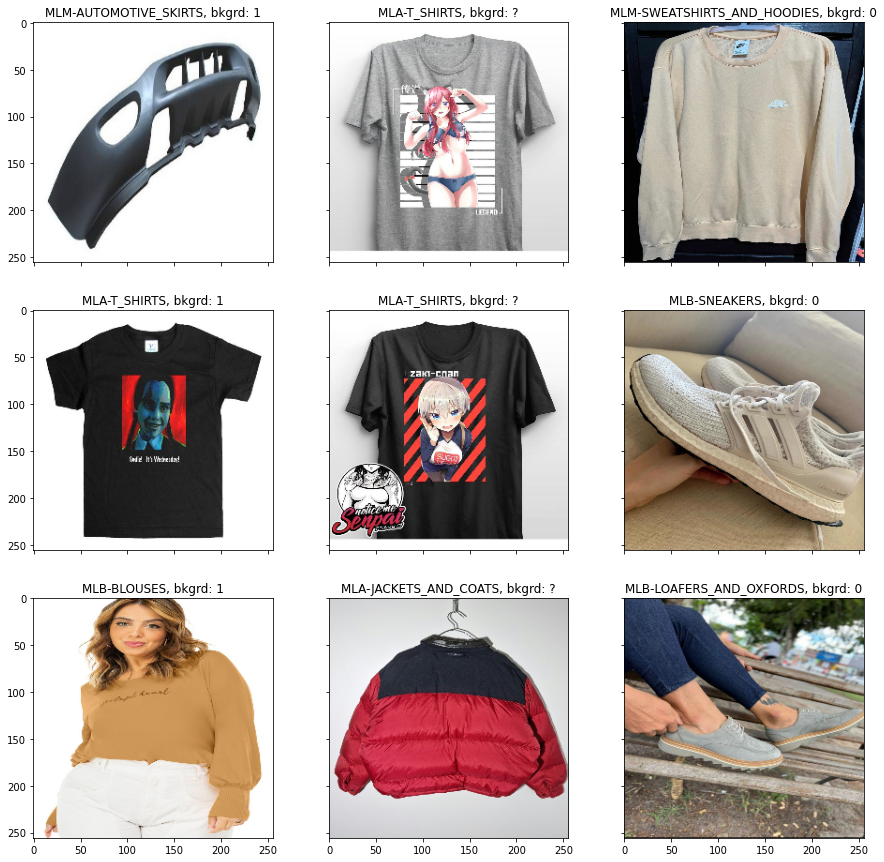

In [8]:
meli_data_set.explore_dataset(seed=8)

Al explorar el dataset podemos verificar que hay una diferencia grande entre los fondos de las imágenes etiquetadas como '1' y '0'. Aunque hay varias imágenes con la etiqueta '?' que podrían ser etiquetadas como '1', las que están más hacia el lado del '0' hacen difícil definir esa frontera. Por esto se decide dejar fuera estas muestras por ahora y tal vez tenerlas en cuenta para más adelante.

Una observación adicional es que en general los tipos de producto están bien etiquetados (a excepción de algunas auto-partes en la categoría AUTOMOTIVE_SKIRTS que se pueden filtrar). Aunque en principio no lo parece, ésta columna (domain_id) y site_id podrían aportar a la solución del problema, pero primero se verá desde las características de la imagen.

Finalmente al observar que los fondos aún siendo del color correcto y planos pueden ser rechazados por su textura, se descarta la hipótesis 3, se unifican las propuestas 1 y 2 adicionando características de textura y es inevitable un análisis con CNN. La hipótesis 5, segmentación semántica, siguie siendo una opción, pero podría necesitar un proceso de etiquetado (se considerará más adelante).

## Primera propuesta

El primer experimento constará de una extracción de características llevando a cabo los siguientes pasos:

1. **umbralizar** (thresholding): Dado que el fondo es notablemente claro en las imágenes positivas, la umbralización permitirá ocultar características de las zonas que no aportan información para resolver el problema (como el producto). La umbralización se realizará a partir de un valor global para la imagen, que puede ser optimizable como hyperparámetro (el umbral adaptativo está pensado para dar uniformidad al fondo).
2. **Obtener características de color**: Para esto se utilizará el espacio de color HSV donde usaremos como características los histogramas de tono (HUE: 15 características) e intensidad (Value: 12 características). Se busca dar cumplimiento a la característica de fondo blanco o crema.
3. **Obtener características morfológicas del fondo**: Se piensa en adquirir el área relativa del fondo (sum(intensidades)/área imagen) y su centro de masa, pero dado que la mayoría de los objetos están centrados en la imagen, todos los centroides tendría una ubicación similar. Para que estas características sean significativas se propone lo siguiente:

      *   Dividir la imagen en 4 (mitad superior, mitad inferior, mitad derecha y mitad izquierda), así la ubicación del centro de masa del fondo puede mostrar una tendencia a acercarse a los bordes (el centro de masa se hace relativo al tamaño de la imagen).
      *   Extraer el área relativa y centros de masa (en 'x' y en 'y') a cada una de las subdivisiones obteniendo 12 características morfológicas.

4. **Obtener características de textura**: Se usa la librería 'mahotas' para extraer 13 de las 14 características de Haralick en los 4 ángulos posibles (52 características).

Con estas características se crea un nuevo dataset con el fin de manipularlo fácilmente sin un pipeline muy complejo en el entrenamiento. El dataset se crea con el script **'create_featured_dataset.py'** en la raíz del proyecto como 'features_dataset.csv'. 

A continuación se presenta un análisis de importancia de estas características:

Clasification accuracy:  94.5945945945946 %


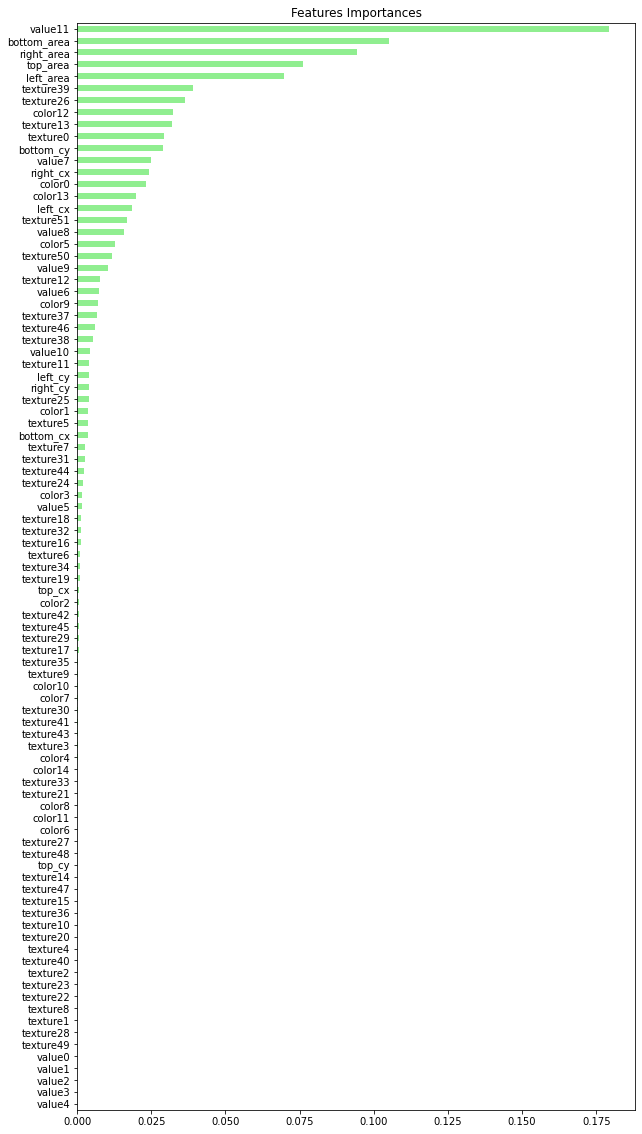

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

random_seed = 1
image_features_df = pd.read_csv('features_dataset.csv')

features = image_features_df.drop('label', axis=1).astype(float)
labels = image_features_df['label'].astype(bool)

x_train, x_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size=0.3, 
                                                    random_state=random_seed)

# Exploratory feature importance análisis with tree based model
rf_model = RandomForestClassifier(n_estimators=100, 
                                  min_samples_leaf=0.05, 
                                  random_state=random_seed)
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)
print('Clasification accuracy: ', accuracy_score(y_test, y_pred)*100, '%')

importances = pd.Series(data=rf_model.feature_importances_,
                        index= x_train.columns)
importances_sorted = importances.sort_values()
importances_sorted.plot(kind='barh', color='lightgreen', figsize=(10, 20))
plt.title('Features Importances')
plt.show()

En el resultado anterior podemos ver que las características extraidas nos permiten obtener un 94.6% de presición con los parámetros establecidos y nos muestra la importancia de cada una de las características en este resultado.

Asi podremos definir que las características más importantes son la alta intensidad (value) del fondo y el área que este ocupa. Luego vemos la importancia del segundo momento angular de Haralick (texture0, 13, 16 y 39) y después otros descriptores de color, alta intensidad, textura y posición.

Vemos que los valores bajos de intensidad no aportan mucho en este caso y muchas de las características de textura pueden ser descartadas.

In [ ]:
import json

# Save feature names
print(importances_sorted[38:].index.values)
with open("configs/important_feature_names.json", "w") as feat_name_file:
    json.dump(importances_sorted[38:].index.tolist(), feat_name_file)

Para definir el modelo que clasificará se plantea un gridsearch multi-modelo en el que se incluyen 3 claisficadores:

1.   Stochastic Gradient Descent, que en el la clase de Sklearn cambia entre SVM y logistic regresion condicionada por la funcion de costo. En este se prueban 3 funciones de penalización y 3 de costo
2.   Multi Layer Perceptron: este se configura con 2 capas ocultas probando 2 diferentes numeros de neuronas, 2 optimizadores y learning rates.
3.   Random Forest: en este se prueban 2 diferentes numeros de estimadores, 2 dunciones de costo, 2 valores máximos de características en cada estimador y 2 valores de limitación para las hojas.

Para el entrenamiento se usa la base de datos con las características mas relevntes en un modelo de K-fold cross validation de 5 subdivisiones.

In [24]:
from trainers.classic_trainer import ClasicKfoldCrossValidationTrainer
from configs.classic_trainer_config import get_grid_search_parámeters

purged_feature = features[importances_sorted[38:].index]

multimodels_trainer =  ClasicKfoldCrossValidationTrainer(None, 
                                (purged_feature, labels),
                                get_grid_search_parámeters(seed = random_seed), 
                                splits=5,
                                seed = random_seed)
multimodels_trainer.train()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

In [25]:
print("Tuned Parameters: {}".format(multimodels_trainer.params))
print("Tuned model score: {}".format(multimodels_trainer.best_score_)
# model_location = 'experiments/num_features/best_model_feature_cls.sav'
# multimodels_trainer.best_model_save(model_location)
# labels_predictions = pickle.load(open(model_location, 'rb')).predict(purged_feature)
# print(classification_report(labels, labels_predictions))

Tuned Parameters: {'model__estimator': RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_leaf=0.001, n_estimators=50, random_state=1), 'model__estimator__criterion': 'entropy', 'model__estimator__max_features': 'sqrt', 'model__estimator__min_samples_leaf': 0.001, 'model__estimator__n_estimators': 50, 'model__estimator__random_state': 1}
              precision    recall  f1-score   support

       False       0.98      0.98      0.98      1837
        True       0.98      0.98      0.98      1863

    accuracy                           0.98      3700
   macro avg       0.98      0.98      0.98      3700
weighted avg       0.98      0.98      0.98      3700



Vemos que para esta evaluación inicial el modelo Random Forest obtiene el mejor resultado con el 96% de accuracy en el metodo k-fold cross validation.

Este resultado se puede optimizar probando modelos más complejos de MLP y optimizando el valor del threshodl en la creación de la base de datos.

## Segunda propueta

Los resultados observados sobre este dataset se ven sorprendentes y aun con cossvalidation la metrica de accurací está sobre el 96%. Con base en este resultado se mirará que puede hacer un modelo convolucional dada la base de datos con imágenens. 

Se propone iniciar con un modelo muy básico utilizando solo 3 capas convolucionales con un pooling que reduce la imagen en (1/4) cada vez. La clasificación se realiza con un MLP de una sola capa escondida con 64 neuronas.

La idea de un modelo simple al iniciar es para evitar overfitting y tener una idea de la complejidad del problema.

Para construir el pipeline de la base de datos se usó la clase de Tensor Flow, tf.data y tf.keras para la construcción del modelo.

In [5]:
from models.conv_meli_fashion_model import ConvMeliFashionModel
from data_loader.meli_data_loader import MeliDataLoader
from trainers.conv_trainer import ConvModelTrainer
from utils.config import process_config
from utils.dirs import create_dirs
import tensorflow as tf


config = process_config("configs/meli_fashion_config.json")
create_dirs([config.callbacks.tensorboard_log_dir, config.callbacks.checkpoint_dir])
data_loader = MeliDataLoader(config)


model = ConvMeliFashionModel(config).model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 64)        

In [6]:
# config.trainer.num_epochs = 10
# config.trainer.batch_size = 64
trainer = ConvModelTrainer(model, data_loader.get_train_test_data(), config)
trainer.train()

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.6166 - accuracy: 0.6619
Epoch 1: val_loss improved from inf to 0.43658, saving model to experiments/2022-10-19/Conv_background_classifier/checkpoints/Conv_background_classifier-01-0.44.hdf5
10/10 [==============================] - 122s 12s/step - loss: 0.6166 - accuracy: 0.6619 - val_loss: 0.4366 - val_accuracy: 0.8594
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.3449 - accuracy: 0.8865
Epoch 2: val_loss improved from 0.43658 to 0.28879, saving model to experiments/2022-10-19/Conv_background_classifier/checkpoints/Conv_background_classifier-02-0.29.hdf5
10/10 [==============================] - 110s 11s/step - loss: 0.3449 - accuracy: 0.8865 - val_loss: 0.2888 - val_accuracy: 0.8828
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.2653 - accuracy: 0.9108 
Epoch 3: val_loss improved from 0.28879 to 0.25556, saving model to experiments/2022-10-19/Conv_background_classifier/c

Al usar gpu se hace dificil replicar los resultados. La clase trainer está sieñada para replicar los resultados si se entrena en CPU

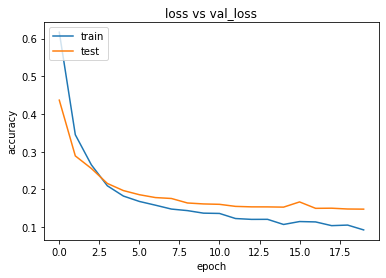

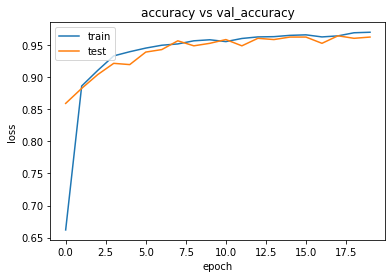

In [8]:
trainer.show_train_history()

Los valores de loss y accuracy de validación que se observanen las gráficas se presenta sobre 2 batches de el dataset de prueba. El desempeño del modelo en los datos de prueba es el siguiente:

In [9]:
trainer.model.evaluate(trainer.test_data.batch(256))

5/5 [==============================] - 60s 13s/step - loss: 0.1179 - accuracy: 0.9635
          Loss             Accuracy


Aunque no se realizó un análisis por cross validation como en la propuesta 1. la clase usada generó los datos con un objeto Stritified K-fold que sepuede usar para ejecutar los entrenamientos en los demas Folds 


`trainer = ConvModelTrainer(model, data_loader.next_kfold(), config)`

`trainer.train()`

Pero basado en el tamaño de la base de datos, en los resultados en la base de datos de prueba y en los resultados del modelo de la propuesta 1, podemos decir que el modelo no está sobreentrenado.

En las graficas de entrenamiento se puede identificarque aun hay un pequeño márgen de mejora


# Parte II

Con el fin de evaluar la solución, se nos hace llegar un nuevo dataset (`productive_data.csv`) con los últimos 5,800 ítems revisados por el equipo de moderadores. La idea en esta parte es que realices una evaluación de tu propuesta y nos hagas saber si estaría lista para puesta en producción. **Nota:** Recuerda que en Mercado Libre trabajamos codo a codo para alcanzar nuestros objetivos así que cualquier duda o solicitud con gusto será atendida por tus compañeros de equipo o stakeholders.

Para la evaluación de los modelos se realiza el mismo tratamiento de datos que en la etapa anterior, esta vez con los datos de producción. En este proceso se identifica que la base de datos no tiene 5800 registros sino 1627, de los cuales 1378 tienen las etiquetas '0' y '1'. Con estos datos se realizará la evaluación.

A continuación se evaluarán cada uno de los modelos propuestos teniendo en cuenta varias de las métricas utilizadas para la clasificación binaria. Se presentarán la matríz de confusión junto con 5 métricas que se pueden obtener de esta.

Además se presentarán las gráficas de sensibilidad y precisión para cambios en el trhreshold que premitirán identificar un umbral que equilibre las métricas.

Finalmente se presentan algunos de los ejemplos que fueron clasificados erroneamente para analizar la posible estrategia de mejora de los métodos.

**NOTA: Los métodos se pueden evaluar sin la necesidad de ejecutar las celdas del proceso de entrenamiento. Para esto se toman los modelos o pesos guradados en la elaboración** 

## Evaluacion del modelo obtenido en la primera propuesta

y_axis: true labe, x_axis: predicted label


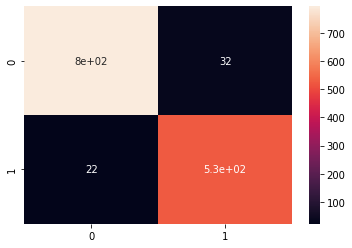

In [5]:
from evaluater.classic_model_evaluator import ClassicModelEvaluator
from data_loader.meli_data_loader import MeliDataLoader
from utils.config import process_config
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import json

config = process_config("configs/meli_fashion_config.json")
config.data_loader.csv_file = "productive_data.csv"
validation_urls = MeliDataLoader(config).x
image_features_df = pd.read_csv('features_validation_dataset.csv')

model_weights_path = "experiments/num_features/best_model_feature_cls.sav"
with open("configs/important_feature_names.json", "r") as feat_name_file:
    selected_features = json.load(feat_name_file)

features = image_features_df.drop('label', axis=1).astype(float)
purged_features = features[selected_features]
labels = image_features_df['label'].astype(bool)

model = []
rf_eval = ClassicModelEvaluator(model, (purged_features,labels) , model_weights_path, validation_urls)
print('y_axis: true labe, x_axis: predicted label')

accuracy =  96.08127721335269 %
f1 =  96.06888643195876 %
sensitivity =  96.00725952813067 %
specificity =  96.13059250302297 %
precision =  94.29590017825312 %


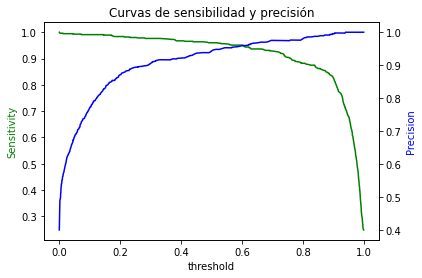

In [6]:
print('accuracy = ', rf_eval.accuracy*100,'%')
print('f1 = ', rf_eval.f1*100,'%')
print('sensitivity = ', rf_eval.sensitivity*100,'%')
print('specificity = ', rf_eval.specificity*100,'%')
print('precision = ', rf_eval.precision*100,'%')

# rf_eval.get_ROC_curves()
# print('\n\n')
rf_eval.get_precision_sensitivity_curves()

Con los resultados obtenidos se puede identificar que la métricas estan todas por encima del 96%, excepto la precisión que se ve afectada por los 32 fasos positivos. 

En la curva de sensibilidad vs precisión es notable que éstas métricas podrían mejorar un poco si la claisficación se realiza con un umbral aproximado 0.6 en véz de 0.5.

A continuación se presentan algunas de las imágenes con una clasificación erronea prsentando los falsos positivos a la derecha y los falsos positivos a la izquierda.

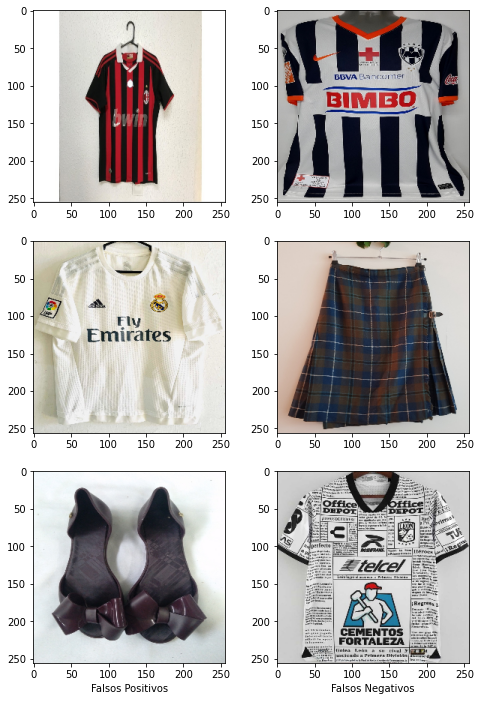

In [15]:
rf_eval.get_bad_results_with_image(num_examples=3)

## Evaluación del modelo obtenido en la segunda propuesta

Loading model checkpoint experiments/2022-10-19/Conv_background_classifier/checkpoints/Conv_background_classifier-20-0.15.hdf5 ...

Model loaded
11/11 [==============================] - 69s 5s/step
y_axis: true labe, x_axis: predicted label


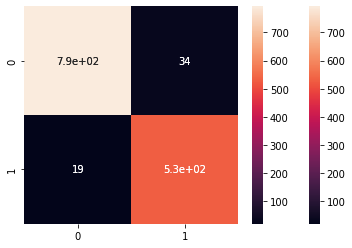

In [7]:
from data_loader.meli_data_loader import MeliDataLoader, MeliFashionDataSet
from models.conv_meli_fashion_model import ConvMeliFashionModel
from evaluater.conv_model_evaluator import ConvModelEvaluator
from utils.config import process_config

# If you want to evaluate a newly trained method, you must set the weights.hdf5 path
model_weights_path = "experiments/2022-10-19/Conv_background_classifier/checkpoints/Conv_background_classifier-20-0.15.hdf5"
config = process_config("configs/meli_fashion_config.json")
config.data_loader.csv_file = "productive_data.csv"
data_loader = MeliDataLoader(config)
model = ConvMeliFashionModel(config)
conv_eval = ConvModelEvaluator(model, data_loader.get_validation_data() , model_weights_path, 128, data_loader.x)
conv_eval.get_conf_mat_metrics()
print('y_axis: true labe, x_axis: predicted label')

accuracy =  96.15384615384616 %
f1 =  96.21909735011808 %
sensitivity =  96.55172413793103 %
specificity =  95.88875453446191 %
precision =  93.99293286219081 %


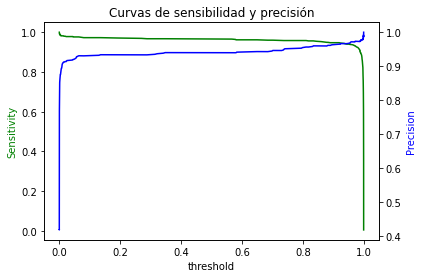

In [8]:
print('Accuracy = ', conv_eval.accuracy*100,'%')
print('F1 = ', conv_eval.f1*100,'%')
print('Sensitivity = ', conv_eval.sensitivity*100,'%')
print('Specificity = ', conv_eval.specificity*100,'%')
print('Precision = ', conv_eval.precision*100,'%')

# conv_eval.get_ROC_curves()
# print('\n\n')
conv_eval.get_precision_sensitivity_curves()

Los resultados obtenidos por este modelo podemos observar una pequeña mejora en la métricas F1 y sensibilidad presentadas en la propuesta anterior. En la matriz de confusión tambien se puede observar mejora en la sensibilidad pero aumentando los falsos positivos lo que afecta la precisión del modelo.

En la curva de sensibilidad vs precisión es notable que éstas métricas se mantienen estables en casi todo el espectro de umbrales y que se podría mejorar un poco si la precisión si la clasificación se realzia con un umbral aproximado 0.95.

A continuación se presentan algunas de las imágenes con una clasificación erronea prsentando los falsos positivos a la derecha y los falsos positivos a la izquierda.

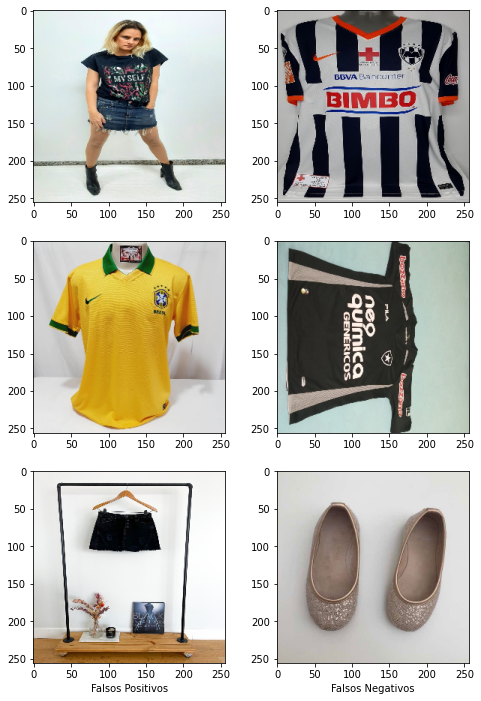

In [5]:
conv_eval.get_bad_results_with_image(num_examples=3)

En la siguiente tabla se pueden comparar las métricas mencionadas en las dos evaluaciones.

Nota: la diferencia presenta la resta de los valores de la columna CNN con la columna Random Forest, así que los valores negativos son representan mejores valores en RandomForest y los positivos mejores valores en CNN

\begin{array}{llll}
                     & {\textbf{Random Forest}} & {\textbf{CNN}} & \textbf{Diferencia} \\
\textbf{Accuracy}    & 96.08                                      & 96.15                            & 0.07                \\
\textbf{F1}          & 96.07                                      & 96.22                            & 0.15                \\
\textbf{Sensitivity} & 96.01                                      & 96.55                            & 0.54                \\
\textbf{Specificity} & 96.13                                      & 95.89                            & -0.24               \\
\textbf{Precision}   & 94.30                                      & 93.99                            & -0.30              
\end{array}

Adelantandome un poco al análisis de la tercera parte, el problema requiere que se tengan los minimos falsos negativos posibles por lo que una de las métricas mas importantes para elegir un método es la sensibilidad 

$Sensibilidad =  \frac{Verdaderos\ positivos}{Verdaderos\ positivos+Falsos\ Negativos}$

Es evidente que la diferencia no es significativa en los modelos pero si se puede identificar que la mayor diferencia entre los 2 es la sensibilidad mejorada por en medio punto porcentual por el modelo CNN que es visible también en el menor numero de falsos negativos que presenta su matríz de confusión.

Hasta este momento ese sería el mejor modelo hasta ahora pero haciendo salvedad que para definir esa superioridad estaría pendiente realizar una prueba de hipotesis haciendo bootstraping con la base de datos de producción.

Algo para adicionar es que es una evaluación inicial y que tanto los modelos presentados como los pipelines de entrada de datos pueden evolucionar.

Estos últimos son el cuello de botella más perceptible en las soluciones propuestas, lo que dificultan procesos como la optimización de parámentros que puedan impactar el entrenamiento modificando los datos de entrada (tamaño de imágen, umbral, espacios de color, etc)

Pasando al análisis de las imágenes mal clasificadas, se observa que el fondo es un poco oscuro y dado que el la segmentación por umbral es el primer proceso que se le realiza a las imágenes antes del entrenamiento, este pudo influir en la pérdida de esta características. Esto nos muestra que podríamos mejorar el método cambiando el umbral, e incluso se podría implementar una custom layer que permitiera entrenar ese parámetro.

# Parte III

Debido al gran volumen de ítems que procesamos día a día, algún error en nuestras soluciones podría llegar a afectar muchos vendedores y generar malas experiencias de usuario en el marketplace. Con lo cual, solemos penalizar bastante los errores de clasificación que involucren bajas erróneas de ítems. Como última tarea, te proponemos plantear un proceso que nos permita maximizar la precisión de tu solución con base a los datos que tienes disponibles hasta el momento.

## Propuesta para maximisar el desempeño

Con los datos y modelos que tengo en este momento se puede realizar un proceso que permita evitar las bajas erroneas de items. 
Este proceso consistiría en clasificar las imágenens en 3 clases basados en las probabilidades predichas por los modelos. Las tres clases serían: Fondo correcto, Fondo incorrecto y fondo a revisar por un moderador

Para visualizar el aporte de este enfoque y como se realizaría se muestra una distrivución de las probabilidades de las predicciónes realizadas por los modelos. En estas distribuciones se pueden ver que existenen en los valores intermedios de las predicciones de probabilidad varios ejemplos clasificados erroneamente.

Luego se presenta el efecto de utilizar la probabilidad de las predicciones para la selección de lagunos de las imágenens en el centro de la distribución para una revisión manual.

## Efecto sobre el modelo Random Forest

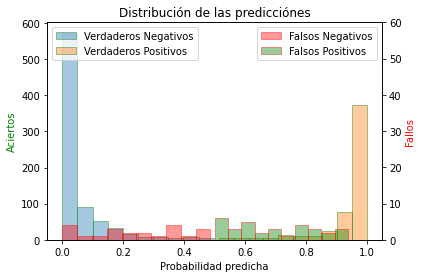

In [ ]:
rf_eval.get_predict_distributions()

In [ ]:
rf_eval.get_moderation_tresh((0.15,0.85))

Tomando un intervalo para moderar:  0.15  a  0.85
la proporcion de imágenes a moderar es del :  12.772133526850508 %
Y el accuracy del las demas predicciones sería de:  99.08485856905158
donde solo se presentan el  0.49916805324459235 % de falsos negativos
y en comparación con el dataset de prueba un  0.43541364296081275 %


In [ ]:
rf_eval.get_moderation_thresh(0.2,0.8)

Tomando un intervalo para moderar:  0.2  a  0.8
la proporcion de imágenes a moderar es del :  9.143686502177069 %
Y el accuracy del las demas predicciones sería de:  98.48242811501598
donde solo se presentan el  0.7188498402555911 % de falsos negativos
y en comparación con el dataset de prueba un  0.6531204644412192 %


## Efecto sobre el modelo Convolucional

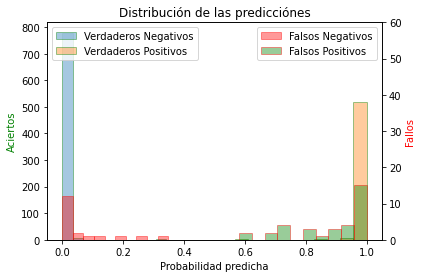

In [5]:
conv_eval.get_predict_distributions()

In [8]:
conv_eval.get_moderation_thresh(0.01,0.99)

Tomando un intervalo para moderar:  0.05  a  0.95
la proporcion de imágenes a moderar es del :  3.555878084179971 %
Y el accuracy del las demas predicciones sería de:  97.74266365688487
donde solo se presentan el  0.9781790820165538 % de falsos negativos
y en comparación con el dataset de prueba un  0.9433962264150944 %


In [11]:
conv_eval.get_moderation_thresh(0.015,0.995)

Tomando un intervalo para moderar:  0.01  a  0.99
la proporcion de imágenes a moderar es del :  6.531204644412192 %
Y el accuracy del las demas predicciones sería de:  98.21428571428571
donde solo se presentan el  0.7763975155279503 % de falsos negativos
y en comparación con el dataset de prueba un  0.7256894049346879 %


Como la idea de las propuestas presentadas es apoyar al equipo de moderación y no reemplazarlos, supongo que los efectos de aplicar este roceso, como se ven en los bloques anteriores aliviarían la tarea de moderación.

Ejemplo, si seleccionamos umbrales de predicción que clasifiquen el 10% de las imágenes para moderación manual, en un día se podrían moderar 20.000 imágenes, moderando manualmente 2000 de estas, la mitad de las que pueden hacer actualmente.